In [4]:
import os
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM
from IPython.display import Audio
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq
from scipy import signal

In [5]:
%matplotlib inline

In [6]:
# some global variables
filepath = '/home/lagvna/slncs/'
mp3_name = 'drilling.mp3'
wav_name = 'drilling.wav'
sample_frequency = 44100
chunk_size = 44100

In [7]:
# converting mp3 to mono wav
sound = AudioSegment.from_mp3(filepath + mp3_name)
sound = sound.set_channels(1)
sound.export(filepath + wav_name, format="wav")

<_io.BufferedRandom name='/home/lagvna/slncs/drilling.wav'>

# EDA

In [8]:
rate, data = wav.read('drilling.wav')

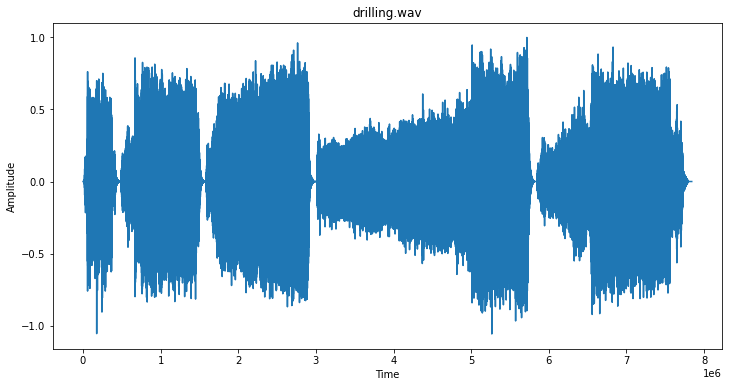

In [9]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(data/np.max(data))
plt.title(wav_name)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [10]:
len(data)/rate

177.79045351473923

/home/lagvna/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


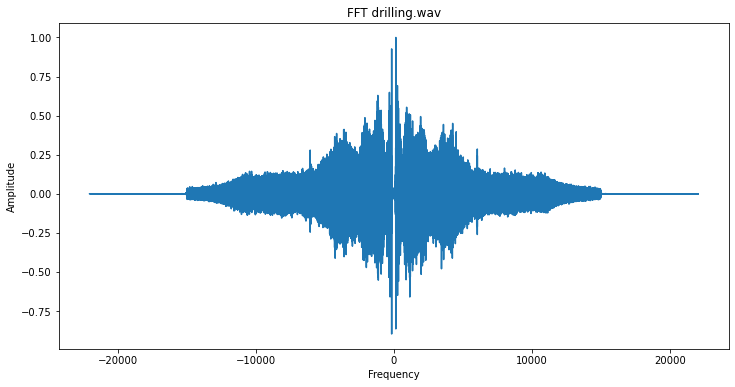

In [11]:
# fft
yf = fft(data)
yf = yf/np.max(yf)
xf = fftfreq(len(data), 1 / rate)

plt.figure(figsize=(12, 6))
plt.plot(xf, yf)
plt.title("FFT " + wav_name)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [12]:
len(data) / sample_frequency

177.79045351473923

In [13]:
# stft
f, t, Zxx = signal.stft(data, nperseg=512)

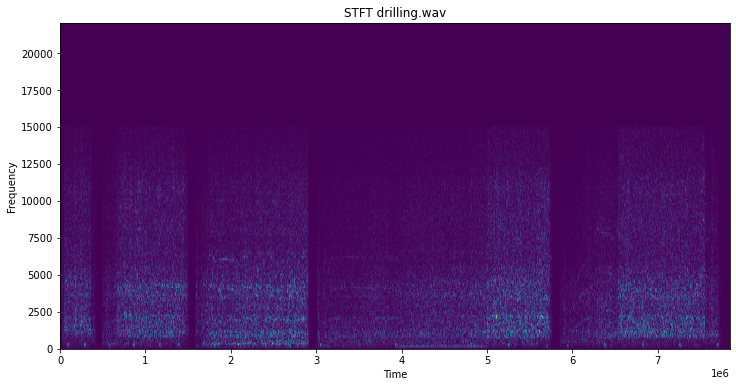

In [14]:
plt.figure(figsize=(12,6))
plt.pcolormesh(t, f*sample_frequency, np.abs(Zxx), vmin=0, shading='flat')
plt.title("STFT "+wav_name)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

# Data preprocessing

In [15]:
def divide_data(recording, chunk_size):
    remainder = len(recording) % chunk_size
    padding_size = chunk_size - remainder
    padding_vector = np.zeros(padding_size)
    padded_recording = np.append(recording, padding_vector)
    chunks = np.split(padded_recording, len(padded_recording)/chunk_size)
    
    return chunks

In [16]:
def fftransform(recording_chunks):
    fft_chunks = []
    for c in recording_chunks:
        fft_chunk = fft(c)
        full_fft_chunk = np.concatenate((np.real(fft_chunk), np.imag(fft_chunk)))
        fft_chunks.append(full_fft_chunk)
    return fft_chunks

In [17]:
def inv_fftransform(fq_chunks):
    chunks = []
    for c in fq_chunks:
        midpoint = c.shape[0] / 2
        real_chunk = c[0:int(midpoint)]
        imag_chunk = c[int(midpoint):]
        # amplitude represented as a complex number corresponding to the frequency
        full_chunk = real_chunk + 1.0j * imag_chunk
        time_chunk = ifft(full_chunk)
        chunks.append(time_chunk)
    return chunks

In [18]:
normalized_data = data / 32767.0
data_chunks = divide_data(normalized_data, chunk_size)
#print(data_chunks)
X = fftransform(data_chunks)
Y = fftransform(data_chunks[1:])
print(np.shape(X))
print(np.shape(Y))

(178, 88200)
(177, 88200)


#### LSTM requires a 3D input in the form of (samples, timesteps, features) ->
https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [19]:
timestep = 10

In [20]:
# padding with zero vectors at the end, for an equal split
while len(X)%timestep != 0:
    X.append(np.zeros(np.shape(X)[1]))
    
while len(Y)%timestep != 0:
    Y.append(np.zeros(np.shape(Y)[1]))

In [21]:
# turning into np array to split examples equally into timesteps, then going back to a list
X = np.array(X)
tmp_x = np.split(X, X.shape[0]/timestep)
x_train = np.stack(tmp_x, axis = 0)

Y = np.array(Y)
tmp_y = np.split(Y, Y.shape[0]/timestep)
y_train = np.stack(tmp_y, axis = 0)

In [22]:
print(np.shape(x_train))
print(np.shape(y_train))

(18, 10, 88200)
(18, 10, 88200)


# Model design and training

In [48]:
NL = 1024

num_frequency_dimensions = (np.shape(X))[1]
a = (np.shape(x_train))[0]
b = (np.shape(x_train))[1]

model = Sequential()
model.add(TimeDistributed(Dense(NL, input_shape=(num_frequency_dimensions, ))))
model.add(LSTM(NL, input_shape=(NL, ), return_sequences=True))
model.add(TimeDistributed(Dense(num_frequency_dimensions, input_shape=(NL, ))))
model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
model.build((a, b, num_frequency_dimensions))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (18, 10, 1024)            90317824  
_________________________________________________________________
lstm_4 (LSTM)                (18, 10, 1024)            8392704   
_________________________________________________________________
time_distributed_7 (TimeDist (18, 10, 88200)           90405000  
Total params: 189,115,528
Trainable params: 189,115,528
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(x_train, y_train, batch_size=10, epochs=1500, verbose=1, validation_split=0.0)

Epoch 1/1500
2/2 [==============================] - 4s 1s/step - loss: 372.1808
Epoch 2/1500
2/2 [==============================] - 3s 1s/step - loss: 346.5730
Epoch 3/1500
2/2 [==============================] - 3s 1s/step - loss: 365.3867
Epoch 4/1500
2/2 [==============================] - 3s 1s/step - loss: 364.8338
Epoch 5/1500
2/2 [==============================] - 3s 1s/step - loss: 357.9215
Epoch 6/1500
2/2 [==============================] - 3s 1s/step - loss: 368.4002
Epoch 7/1500
2/2 [==============================] - 3s 1s/step - loss: 355.2693
Epoch 8/1500
2/2 [==============================] - 3s 1s/step - loss: 360.3257
Epoch 9/1500
2/2 [==============================] - 3s 1s/step - loss: 355.0500
Epoch 10/1500
2/2 [==============================] - 3s 1s/step - loss: 372.3079
Epoch 11/1500
2/2 [==============================] - 3s 1s/step - loss: 359.1548
Epoch 12/1500
2/2 [==============================] - 3s 1s/step - loss: 339.7178
Epoch 13/1500
2/2 [==================

2/2 [==============================] - 3s 1s/step - loss: 310.9052
Epoch 103/1500
2/2 [==============================] - 3s 1s/step - loss: 299.3037
Epoch 104/1500
2/2 [==============================] - 3s 1s/step - loss: 292.3207
Epoch 105/1500
2/2 [==============================] - 3s 1s/step - loss: 294.9322
Epoch 106/1500
2/2 [==============================] - 3s 1s/step - loss: 306.2805
Epoch 107/1500
2/2 [==============================] - 3s 1s/step - loss: 296.0210
Epoch 108/1500
2/2 [==============================] - 3s 1s/step - loss: 319.1771
Epoch 109/1500
2/2 [==============================] - 3s 1s/step - loss: 292.1396
Epoch 110/1500
2/2 [==============================] - 3s 1s/step - loss: 275.7219
Epoch 111/1500
2/2 [==============================] - 3s 1s/step - loss: 292.9492
Epoch 112/1500
2/2 [==============================] - 3s 1s/step - loss: 308.7188
Epoch 113/1500
2/2 [==============================] - 3s 1s/step - loss: 325.4520
Epoch 114/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 287.8306
Epoch 203/1500
2/2 [==============================] - 3s 1s/step - loss: 278.8564
Epoch 204/1500
2/2 [==============================] - 3s 1s/step - loss: 278.2142
Epoch 205/1500
2/2 [==============================] - 3s 1s/step - loss: 260.3163
Epoch 206/1500
2/2 [==============================] - 3s 1s/step - loss: 260.8530
Epoch 207/1500
2/2 [==============================] - 3s 1s/step - loss: 262.2877
Epoch 208/1500
2/2 [==============================] - 3s 1s/step - loss: 257.0407
Epoch 209/1500
2/2 [==============================] - 3s 1s/step - loss: 296.7434
Epoch 210/1500
2/2 [==============================] - 3s 1s/step - loss: 262.2329
Epoch 211/1500
2/2 [==============================] - 3s 1s/step - loss: 265.8818
Epoch 212/1500
2/2 [==============================] - 3s 1s/step - loss: 270.4618
Epoch 213/1500
2/2 [==============================] - 3s 1s/step - loss: 280.8629
Epoch 214/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 247.5278
Epoch 303/1500
2/2 [==============================] - 3s 1s/step - loss: 230.4601
Epoch 304/1500
2/2 [==============================] - 3s 1s/step - loss: 240.1842
Epoch 305/1500
2/2 [==============================] - 3s 1s/step - loss: 233.9595
Epoch 306/1500
2/2 [==============================] - 3s 1s/step - loss: 241.7285
Epoch 307/1500
2/2 [==============================] - 3s 1s/step - loss: 258.3806
Epoch 308/1500
2/2 [==============================] - 3s 1s/step - loss: 230.5770
Epoch 309/1500
2/2 [==============================] - 3s 1s/step - loss: 226.1491
Epoch 310/1500
2/2 [==============================] - 3s 1s/step - loss: 231.0438
Epoch 311/1500
2/2 [==============================] - 3s 1s/step - loss: 245.4256
Epoch 312/1500
2/2 [==============================] - 3s 1s/step - loss: 229.9268
Epoch 313/1500
2/2 [==============================] - 3s 1s/step - loss: 257.1482
Epoch 314/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 233.3323
Epoch 403/1500
2/2 [==============================] - 3s 1s/step - loss: 226.1343
Epoch 404/1500
2/2 [==============================] - 3s 1s/step - loss: 237.2580
Epoch 405/1500
2/2 [==============================] - 3s 1s/step - loss: 231.3444
Epoch 406/1500
2/2 [==============================] - 3s 1s/step - loss: 221.6261
Epoch 407/1500
2/2 [==============================] - 3s 1s/step - loss: 215.2549
Epoch 408/1500
2/2 [==============================] - 3s 1s/step - loss: 223.4890
Epoch 409/1500
2/2 [==============================] - 3s 1s/step - loss: 218.2730
Epoch 410/1500
2/2 [==============================] - 3s 1s/step - loss: 232.4148
Epoch 411/1500
2/2 [==============================] - 3s 1s/step - loss: 222.3534
Epoch 412/1500
2/2 [==============================] - 3s 1s/step - loss: 231.8684
Epoch 413/1500
2/2 [==============================] - 3s 1s/step - loss: 236.9431
Epoch 414/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 213.0003
Epoch 503/1500
2/2 [==============================] - 3s 1s/step - loss: 211.5112
Epoch 504/1500
2/2 [==============================] - 3s 1s/step - loss: 187.2444
Epoch 505/1500
2/2 [==============================] - 3s 1s/step - loss: 236.4393
Epoch 506/1500
2/2 [==============================] - 3s 1s/step - loss: 203.4500
Epoch 507/1500
2/2 [==============================] - 3s 1s/step - loss: 199.5796
Epoch 508/1500
2/2 [==============================] - 3s 1s/step - loss: 200.2885
Epoch 509/1500
2/2 [==============================] - 3s 1s/step - loss: 213.3780
Epoch 510/1500
2/2 [==============================] - 3s 1s/step - loss: 208.2831
Epoch 511/1500
2/2 [==============================] - 3s 1s/step - loss: 198.5608
Epoch 512/1500
2/2 [==============================] - 3s 1s/step - loss: 205.3726
Epoch 513/1500
2/2 [==============================] - 3s 1s/step - loss: 218.7067
Epoch 514/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 178.9773
Epoch 603/1500
2/2 [==============================] - 3s 1s/step - loss: 177.8824
Epoch 604/1500
2/2 [==============================] - 3s 1s/step - loss: 208.0925
Epoch 605/1500
2/2 [==============================] - 3s 1s/step - loss: 198.1686
Epoch 606/1500
2/2 [==============================] - 3s 1s/step - loss: 179.7912
Epoch 607/1500
2/2 [==============================] - 3s 1s/step - loss: 205.9874
Epoch 608/1500
2/2 [==============================] - 3s 1s/step - loss: 186.4422
Epoch 609/1500
2/2 [==============================] - 3s 1s/step - loss: 202.9043
Epoch 610/1500
2/2 [==============================] - 3s 1s/step - loss: 185.2187
Epoch 611/1500
2/2 [==============================] - 3s 1s/step - loss: 186.9673
Epoch 612/1500
2/2 [==============================] - 3s 1s/step - loss: 199.5124
Epoch 613/1500
2/2 [==============================] - 3s 1s/step - loss: 188.8904
Epoch 614/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 178.5812
Epoch 703/1500
2/2 [==============================] - 3s 1s/step - loss: 177.2633
Epoch 704/1500
2/2 [==============================] - 3s 1s/step - loss: 188.3690
Epoch 705/1500
2/2 [==============================] - 3s 1s/step - loss: 178.6135
Epoch 706/1500
2/2 [==============================] - 3s 1s/step - loss: 168.0553
Epoch 707/1500
2/2 [==============================] - 3s 1s/step - loss: 177.6592
Epoch 708/1500
2/2 [==============================] - 3s 1s/step - loss: 163.0751
Epoch 709/1500
2/2 [==============================] - 3s 1s/step - loss: 180.5980
Epoch 710/1500
2/2 [==============================] - 3s 1s/step - loss: 188.4861
Epoch 711/1500
2/2 [==============================] - 3s 1s/step - loss: 179.3052
Epoch 712/1500
2/2 [==============================] - 3s 1s/step - loss: 189.2010
Epoch 713/1500
2/2 [==============================] - 3s 1s/step - loss: 172.1535
Epoch 714/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 167.5317
Epoch 803/1500
2/2 [==============================] - 3s 1s/step - loss: 179.7029
Epoch 804/1500
2/2 [==============================] - 3s 1s/step - loss: 181.8567
Epoch 805/1500
2/2 [==============================] - 3s 1s/step - loss: 178.3256
Epoch 806/1500
2/2 [==============================] - 3s 1s/step - loss: 179.3033
Epoch 807/1500
2/2 [==============================] - 3s 1s/step - loss: 173.1965
Epoch 808/1500
2/2 [==============================] - 3s 1s/step - loss: 178.4352
Epoch 809/1500
2/2 [==============================] - 3s 1s/step - loss: 180.4412
Epoch 810/1500
2/2 [==============================] - 3s 1s/step - loss: 159.7580
Epoch 811/1500
2/2 [==============================] - 3s 1s/step - loss: 168.2669
Epoch 812/1500
2/2 [==============================] - 3s 1s/step - loss: 166.2667
Epoch 813/1500
2/2 [==============================] - 3s 1s/step - loss: 155.4320
Epoch 814/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 165.5707
Epoch 903/1500
2/2 [==============================] - 3s 1s/step - loss: 161.6009
Epoch 904/1500
2/2 [==============================] - 3s 1s/step - loss: 158.9301
Epoch 905/1500
2/2 [==============================] - 3s 1s/step - loss: 154.6333
Epoch 906/1500
2/2 [==============================] - 3s 1s/step - loss: 158.6724
Epoch 907/1500
2/2 [==============================] - 3s 1s/step - loss: 168.8223
Epoch 908/1500
2/2 [==============================] - 3s 1s/step - loss: 151.0945
Epoch 909/1500
2/2 [==============================] - 3s 1s/step - loss: 159.3038
Epoch 910/1500
2/2 [==============================] - 3s 1s/step - loss: 156.4230
Epoch 911/1500
2/2 [==============================] - 3s 1s/step - loss: 152.0112
Epoch 912/1500
2/2 [==============================] - 3s 1s/step - loss: 161.1560
Epoch 913/1500
2/2 [==============================] - 3s 1s/step - loss: 170.1389
Epoch 914/1500
2/2 [===========

2/2 [==============================] - 3s 1s/step - loss: 144.9888
Epoch 1003/1500
2/2 [==============================] - 3s 1s/step - loss: 153.7378
Epoch 1004/1500
2/2 [==============================] - 3s 1s/step - loss: 151.6607
Epoch 1005/1500
2/2 [==============================] - 3s 1s/step - loss: 159.7952
Epoch 1006/1500
2/2 [==============================] - 3s 1s/step - loss: 146.6020
Epoch 1007/1500
2/2 [==============================] - 3s 1s/step - loss: 147.8924
Epoch 1008/1500
2/2 [==============================] - 3s 1s/step - loss: 142.2831
Epoch 1009/1500
2/2 [==============================] - 3s 1s/step - loss: 151.9088
Epoch 1010/1500
2/2 [==============================] - 3s 1s/step - loss: 156.8680
Epoch 1011/1500
2/2 [==============================] - 3s 1s/step - loss: 154.3354
Epoch 1012/1500
2/2 [==============================] - 3s 1s/step - loss: 165.0995
Epoch 1013/1500
2/2 [==============================] - 3s 1s/step - loss: 152.7276
Epoch 1014/1500
2/2 

2/2 [==============================] - 3s 1s/step - loss: 142.8486
Epoch 1101/1500
2/2 [==============================] - 3s 1s/step - loss: 142.1157
Epoch 1102/1500
2/2 [==============================] - 3s 1s/step - loss: 133.3968
Epoch 1103/1500
2/2 [==============================] - 3s 1s/step - loss: 145.0343
Epoch 1104/1500
2/2 [==============================] - 3s 1s/step - loss: 143.9528
Epoch 1105/1500
2/2 [==============================] - 3s 1s/step - loss: 143.3342
Epoch 1106/1500
2/2 [==============================] - 3s 1s/step - loss: 137.2828
Epoch 1107/1500
2/2 [==============================] - 3s 1s/step - loss: 151.9122
Epoch 1108/1500
2/2 [==============================] - 3s 1s/step - loss: 150.1695
Epoch 1109/1500
2/2 [==============================] - 3s 1s/step - loss: 142.6549
Epoch 1110/1500
2/2 [==============================] - 3s 1s/step - loss: 148.7353
Epoch 1111/1500
2/2 [==============================] - 3s 1s/step - loss: 149.6125
Epoch 1112/1500
2/2 

2/2 [==============================] - 3s 1s/step - loss: 135.3571
Epoch 1199/1500
2/2 [==============================] - 3s 1s/step - loss: 131.9957
Epoch 1200/1500
2/2 [==============================] - 3s 1s/step - loss: 138.0231
Epoch 1201/1500
2/2 [==============================] - 3s 1s/step - loss: 133.4146
Epoch 1202/1500
2/2 [==============================] - 3s 1s/step - loss: 133.7212
Epoch 1203/1500
2/2 [==============================] - 3s 1s/step - loss: 143.5791
Epoch 1204/1500
2/2 [==============================] - 3s 1s/step - loss: 138.9264
Epoch 1205/1500
2/2 [==============================] - 3s 1s/step - loss: 133.1402
Epoch 1206/1500
2/2 [==============================] - 3s 1s/step - loss: 132.7223
Epoch 1207/1500
2/2 [==============================] - 3s 1s/step - loss: 135.6517
Epoch 1208/1500
2/2 [==============================] - 3s 1s/step - loss: 146.3079
Epoch 1209/1500
2/2 [==============================] - 3s 1s/step - loss: 137.5522
Epoch 1210/1500
2/2 

2/2 [==============================] - 3s 1s/step - loss: 149.4989
Epoch 1297/1500
2/2 [==============================] - 3s 1s/step - loss: 148.5238
Epoch 1298/1500
2/2 [==============================] - 3s 1s/step - loss: 135.5821
Epoch 1299/1500
2/2 [==============================] - 3s 1s/step - loss: 129.5108
Epoch 1300/1500
2/2 [==============================] - 3s 1s/step - loss: 132.2664
Epoch 1301/1500
2/2 [==============================] - 3s 1s/step - loss: 139.1776
Epoch 1302/1500
2/2 [==============================] - 3s 1s/step - loss: 129.2637
Epoch 1303/1500
2/2 [==============================] - 3s 1s/step - loss: 135.5054
Epoch 1304/1500
2/2 [==============================] - 3s 1s/step - loss: 135.2393
Epoch 1305/1500
2/2 [==============================] - 3s 1s/step - loss: 135.9215
Epoch 1306/1500
2/2 [==============================] - 3s 1s/step - loss: 140.8551
Epoch 1307/1500
2/2 [==============================] - 3s 1s/step - loss: 134.8126
Epoch 1308/1500
2/2 

2/2 [==============================] - 3s 1s/step - loss: 122.5151
Epoch 1395/1500
2/2 [==============================] - 3s 1s/step - loss: 111.8479
Epoch 1396/1500
2/2 [==============================] - 3s 1s/step - loss: 121.1290
Epoch 1397/1500
2/2 [==============================] - 3s 1s/step - loss: 132.3323
Epoch 1398/1500
2/2 [==============================] - 3s 1s/step - loss: 120.6903
Epoch 1399/1500
2/2 [==============================] - 3s 1s/step - loss: 124.6435
Epoch 1400/1500
2/2 [==============================] - 3s 1s/step - loss: 115.2971
Epoch 1401/1500
2/2 [==============================] - 3s 1s/step - loss: 124.5230
Epoch 1402/1500
2/2 [==============================] - 3s 1s/step - loss: 129.5001
Epoch 1403/1500
2/2 [==============================] - 3s 1s/step - loss: 126.4891
Epoch 1404/1500
2/2 [==============================] - 3s 1s/step - loss: 117.9609
Epoch 1405/1500
2/2 [==============================] - 3s 1s/step - loss: 125.4082
Epoch 1406/1500
2/2 

2/2 [==============================] - 3s 1s/step - loss: 114.2737
Epoch 1493/1500
2/2 [==============================] - 3s 1s/step - loss: 121.1789
Epoch 1494/1500
2/2 [==============================] - 3s 1s/step - loss: 119.7861
Epoch 1495/1500
2/2 [==============================] - 3s 1s/step - loss: 118.7874
Epoch 1496/1500
2/2 [==============================] - 3s 1s/step - loss: 132.6066
Epoch 1497/1500
2/2 [==============================] - 3s 1s/step - loss: 120.9890
Epoch 1498/1500
2/2 [==============================] - 3s 1s/step - loss: 113.9124
Epoch 1499/1500
2/2 [==============================] - 3s 1s/step - loss: 118.7911
Epoch 1500/1500
2/2 [==============================] - 3s 1s/step - loss: 121.3561


# Audio generation

In [52]:
seed = x_train[0]
gen_length = 10
# 1 sample with a no of timesteps and corresponding no of features
seed = np.reshape(seed, (1, seed.shape[0], seed.shape[1]))
#print(seed.shape)

output = []
for i in range(gen_length):
    generated_piece = model.predict(seed)
    #print(np.shape(generated_piece))
    if i == 0:
        for j in range(generated_piece.shape[1]):
            output.append(generated_piece[i][j].copy())
    else:
        #print(gen_piece[0][gen_piece.shape[1]-1])
        output.append(generated_piece[0][generated_piece.shape[1]-1].copy()) 
    
    new_seed = generated_piece[0][generated_piece.shape[1]-1]
    new_seed = np.reshape(new_seed, (1, 1, new_seed.shape[0]))
    seed = np.concatenate((seed, new_seed), axis=1)
    #print(np.shape(seed))
#print(output)

In [53]:
gen_file_path = '/home/lagvna/slncs/gen_sound.wav'
inv_output = inv_fftransform(output)
print(np.shape(output))
gen_file = np.concatenate(inv_output)
final_file = gen_file * 32767.0
final_file = final_file.astype('int16')
wav.write(gen_file_path, sample_frequency, final_file)

(19, 88200)


<ipython-input-53-77d1b581b38d>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  final_file = final_file.astype('int16')


In [54]:
Audio(gen_file_path)